In [1]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import TensorBoard
from datetime import datetime
from keras import Sequential, Input, Model
import pandas as pd
from keras.layers import *
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.optimizers import Adam
from sklearn import preprocessing
from keras.utils import plot_model
import copy
import warnings

warnings.filterwarnings('ignore')
np.random.seed(666)  

Using TensorFlow backend.
/home/adc/miniconda3/envs/tf1.0/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/adc/miniconda3/envs/tf1.0/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/adc/miniconda3/envs/tf1.0/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/adc/miniconda3/envs/tf1

In [2]:
lambda_ = 0.5

def compute_score(y_true, y_pred):
    d = y_pred - y_true
    return np.sum(np.exp(d[d >= 0] / 10) - 1) + np.sum(np.exp(-1 * d[d < 0] / 13) - 1)


def compute_rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))


def compute_penalized_rmse(y_true, y_pred):
    diff = y_pred - y_true
    positive = np.maximum(diff, 0)
    negative = np.minimum(diff, 0)
    return np.sqrt(np.mean(np.square(positive) * (1 + lambda_) + np.square(negative)))


def score(y_true, y_pred):
    diff = y_pred - y_true
    positive = K.maximum(diff, 0)
    negative = K.minimum(diff, 0)
    return K.sqrt(K.mean(K.square(positive) * (1 + lambda_) + K.square(negative)))


def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


def data_generate(item_unit, time_steps, features_column, upper):
    data_matrix = item_unit[features_column].values
    label_matrix = item_unit[['RUL']].values
    num_cycles = data_matrix.shape[0]

    for end in range(int(time_steps / 3), num_cycles):
        if end < time_steps:  # 需要进行padding
            data_item = np.pad(data_matrix[0: end, :], ((time_steps - end, 0), (0, 0)), 'constant')
        else:  # 不需要进行padding
            data_item = data_matrix[end - time_steps: end, :]
        yield data_item, np.minimum(label_matrix[end], upper)


def split(train_df, sequence_length, sequence_cols, upper):
    seq_array = []
    label_array = []

    generator = (list(data_generate(train_df[train_df['id'] == id],
                                    sequence_length,
                                    sequence_cols, 
                                    upper))
                 for id in train_df['id'].unique())
    arr = np.array(list(generator))
    for item_unit in arr:
        for item_slice in item_unit:
            seq_array.append(item_slice[0])
            label_array.append(item_slice[1])

    return np.array(seq_array), np.array(label_array)


def data_handle(train_df, test_df, truth_df):
    rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    train_df = train_df.merge(rul, on=['id'], how='left')
    train_df['RUL'] = train_df['max'] - train_df['cycle']
    train_df.drop('max', axis=1, inplace=True)

    # MinMax normalization (from 0 to 1)
    train_df['cycle_norm'] = train_df['cycle']
    cols_normalize = train_df.columns.difference(['id', 'cycle', 'RUL'])
    min_max_scaler = preprocessing.MinMaxScaler()
    norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                                 columns=cols_normalize,
                                 index=train_df.index)
    join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
    train_df = join_df.reindex(columns=train_df.columns)

    # Test Data
    test_df['cycle_norm'] = test_df['cycle']
    norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                                columns=cols_normalize,
                                index=test_df.index)
    test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
    test_df = test_join_df.reindex(columns=test_df.columns)
    test_df = test_df.reset_index(drop=True)

    # We use the ground truth dataset to generate labels for the test data.
    # generate column max for test data
    rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    truth_df.columns = ['more']
    truth_df['id'] = truth_df.index + 1
    truth_df['max'] = rul['max'] + truth_df['more']
    truth_df.drop('more', axis=1, inplace=True)

    # generate RUL for test data
    test_df = test_df.merge(truth_df, on=['id'], how='left')
    test_df['RUL'] = test_df['max'] - test_df['cycle']
    test_df.drop('max', axis=1, inplace=True)
    return train_df, test_df


def read_data(filename='FD001'):
    train_df = pd.read_csv('../datasets/phm/train_' + filename + '.txt', sep=" ", header=None)
    train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
    train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                        's15', 's16', 's17', 's18', 's19', 's20', 's21']

    train_df = train_df.sort_values(['id', 'cycle'])

    test_df = pd.read_csv('../datasets/phm/test_' + filename + '.txt', sep=" ", header=None)
    test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
    test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                       's15', 's16', 's17', 's18', 's19', 's20', 's21']

    truth_df = pd.read_csv('../datasets/phm/RUL_' + filename + '.txt', sep=" ", header=None)
    truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
    return train_df, test_df, truth_df


# 查看RUL分布情况

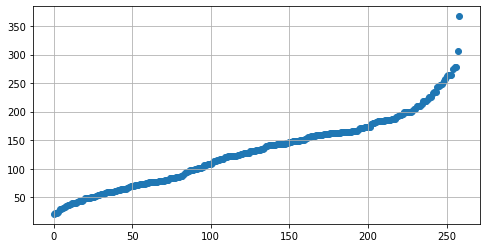

In [64]:
train_df, test_df, truth_df = read_data(filename)
train_rul_values = train_df.groupby(['id']).count()['cycle'].values
test_rul_values = test_df.groupby(['id']).count()['cycle'].values

fig = plt.figure(figsize = (8, 4))
plt.grid(True)
plt.scatter(list(range(len(test_rul_values))), sorted(test_rul_values))
plt.show()

# 使用LGB模型

In [164]:
seq_array = seq_array.reshape((seq_array.shape[0], -1))
label_array = label_array[:, 0]
train_n = int(seq_array.shape[0] * 0.8)

X_train = seq_array[:train_n, :]
y_train = label_array[:train_n]

X_val = seq_array[train_n:, :]
y_val = label_array[train_n:]

lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val)

In [ ]:
# 没有使用
params = {
    'task': 'train',
    'boosting_type': 'gbdt',  # 设置提升类型
    'objective': 'rmse', # 目标函数
    'metric': {'rmse'},  # 评估函数
    'num_leaves': 31,   # 叶子节点数
    'learning_rate': 0.05,  # 学习速率
    'feature_fraction': 0.9, # 建树的特征选择比例
    'bagging_fraction': 0.8, # 建树的样本采样比例
    'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
    'verbose': 1 # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
}
def evaluate_lgb(test_df, model, upper, plot_=True, title=None, noise=False, sigma = 0.1):
    seq_array_test_last = [test_df[test_df['id'] == id][sequence_cols].values[-sequence_length:] for id in test_df['id'].unique()]
    
    for id_ in test_df['id'].unique() - 1:
        length_ = seq_array_test_last[id_].shape[0]
        if noise: 
            mean_ = seq_array_test_last[id_][:, :-1].mean()
            index_ = np.random.randint(0, length_)
            noise_ = np.random.normal(loc=mean_, scale=sigma, size=(seq_array_test_last[id_].shape[1] - 1))
            seq_array_test_last[id_][index_, :-1] = noise_
        
        if length_ < sequence_length:
            seq_array_test_last[id_] = np.pad(seq_array_test_last[id_], ((sequence_length - length_, 0), (0, 0)), 'constant')
        
    seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
    
    label_array_test_last = test_df.groupby('id')['RUL'].nth(-1).values
    seq_array_test_last = seq_array_test_last.reshape((seq_array_test_last.shape[0], -1))
    y_pred_test = model.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    sort_ids = y_true_test.argsort() 
    y_true_test = y_true_test[sort_ids] 
    y_true_test_clip = clip(copy.deepcopy(y_true_test), upper)
    
    y_pred_test = y_pred_test[sort_ids]
    y_pred_test = clip(y_pred_test, upper)

    print('Score: ', compute_score(y_true_test_clip, y_pred_test))
    print('RMSE: ', compute_rmse(y_true_test_clip, y_pred_test))
    print('MSE: ', compute_rmse(y_true_test_clip, y_pred_test) ** 2)
    print('Penalized RMSE: ', compute_penalized_rmse(y_true_test_clip, y_pred_test))
    
    if plot_:
        fig = plot_result(y_true_test, y_pred_test)
        if title:
            fig.savefig('./plot/' + title + '.eps', dpi=600, format='eps')
    return compute_score(y_true_test_clip, y_pred_test), compute_rmse(y_true_test_clip, y_pred_test), compute_penalized_rmse(y_true_test_clip, y_pred_test)


gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=lgb_val,
    early_stopping_rounds=50)

In [ ]:
filename = 'FD004'
train_df, test_df, truth_df = read_data(filename)
train_df, test_df = data_handle(train_df, test_df, truth_df)
sequence_cols = ['s' + str(i) for i in set(range(1, 22))] + ['setting1', 'setting2', 'setting3', 'cycle_norm']

evaluate_lgb(test_df, gbm, upper=160, title='FD004')

## 训练数据构造

In [3]:
filename = 'FD003'
train_df, test_df, truth_df = read_data(filename)

train_df, test_df = data_handle(train_df, test_df, truth_df)

sequence_length = 100
sequence_cols = ['s' + str(i) for i in set(range(1, 22))] + ['setting1', 'setting2', 'setting3', 'cycle_norm']

if filename == 'FD001':
    upper = 130
    sequence_cols = [x for x in sequence_cols if x not in ['s1', 's5', 's10', 's16', 's18', 's19', 'setting3']]
elif filename == 'FD003':
    upper = 130
    sequence_cols = [x for x in sequence_cols if x not in ['s1', 's5', 's16', 's18', 's19', 'setting3']]
else:
    upper = 160
    sequence_cols = ['s' + str(i) for i in set(range(1, 22))] + ['setting1', 'setting2', 'setting3', 'cycle_norm']

seq_array, label_array = split(train_df, sequence_length, sequence_cols, upper)

print('Data Shape: ', seq_array.shape)
print('Label Shape: ', label_array.shape)

# Save Train Data
saved_date_filename = './data/' + filename 
np.save(saved_date_filename + '-train.npy', seq_array)
np.save(saved_date_filename + '-label.npy', label_array)

Data Shape:  (21420, 100, 19)
Label Shape:  (21420, 1)


## Model定义与训练

In [4]:
def build_model(nb_features, sequence_length_):
    inp = Input(shape=(sequence_length_, nb_features))

    x = Convolution1D(filters=8, kernel_size=3, strides=1, activation='relu', padding='same')(inp)
    x = Convolution1D(filters=8, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = BatchNormalization()(x)

    # Reconstruction 
    reconstruction = UpSampling1D(size=2)(x)
    reconstruction = Convolution1D(filters=8, kernel_size=3, strides=1, activation='relu', padding='same')(
        reconstruction)
    reconstruction = Convolution1D(filters=8, kernel_size=3, strides=1, activation='relu', padding='same')(
        reconstruction)
    reconstruction = Convolution1D(filters=nb_features, kernel_size=3, strides=1, activation='softmax', padding='same',
                                   name='reconstruction')(reconstruction)

    # Output
    output = Convolution1D(filters=12, kernel_size=3, strides=2, activation='relu', padding='same')(x)
    output = Convolution1D(filters=12, kernel_size=3, strides=2, activation='relu', padding='same')(output)
    output = Dropout(0.2)(output)
    output = MaxPooling1D(pool_size=2, padding='same')(output)
    output = BatchNormalization()(output)

    output = Bidirectional(LSTM(units=24, return_sequences=True, activation='relu'))(output)
    output = Dropout(0.2)(output)
    output = MaxPooling1D(pool_size=2, padding='same')(output)
    output = BatchNormalization()(output)

    output = GlobalAveragePooling1D()(output)
    output = Dropout(0.2)(output)
    output = Dense(units=1, name='output')(output)

    model = Model(inputs=[inp], outputs=[output, reconstruction])
    model.compile(optimizer=Adam(epsilon=1e-8),
                  loss={'output': score, 'reconstruction': rmse},
                  loss_weights={'output': 1, 'reconstruction': 1.}
                  )
    return model


In [ ]:
model = build_model(seq_array.shape[2], sequence_length)

history = model.fit(
    x=seq_array,
    y={'output': label_array, 'reconstruction': seq_array},
    epochs=200,
    batch_size=128 * 8,
    verbose=2,
    validation_split=0.2,
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='min'),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=15, min_lr=1e-8),
        keras.callbacks.ModelCheckpoint(filepath='./ckpt_opt/' + filename + '.h5', monitor='val_loss', save_best_only=True, verbose=1)
        # TensorBoard(log_dir='/home/qihang/paper/tensorboard/phm/' + "{0:%Y-%m-%d %H:%M:%S/}".format(datetime.now()))
    ])


## 模型评估

In [5]:
def evaluate(test_df, model, upper, plot_=True, title=None, noise=False, sigma = 0.1, debug=True):
    seq_array_test_last = [test_df[test_df['id'] == id][sequence_cols].values[-sequence_length:] for id in test_df['id'].unique()]
    
    for id_ in test_df['id'].unique() - 1:
        length_ = seq_array_test_last[id_].shape[0]
        if noise and sigma != 0.0: 
            mean_ = seq_array_test_last[id_][:, :-1].mean()
            index_ = np.random.randint(0, length_)
            noise_ = np.random.normal(loc=mean_, scale=sigma, size=(seq_array_test_last[id_].shape[1] - 1))
            seq_array_test_last[id_][index_, :-1] = noise_
        
        if length_ < sequence_length:
            seq_array_test_last[id_] = np.pad(seq_array_test_last[id_], ((sequence_length - length_, 0), (0, 0)), 'constant')
        
    seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
    
    label_array_test_last = test_df.groupby('id')['RUL'].nth(-1).values
     
    y_pred_test = model.predict(seq_array_test_last)[0][:, 0]
    y_true_test = label_array_test_last

    sort_ids = y_true_test.argsort() 
    y_true_test = y_true_test[sort_ids] 
    y_true_test_clip = clip(copy.deepcopy(y_true_test), upper)
    
    y_pred_test = y_pred_test[sort_ids]
    y_pred_test = clip(y_pred_test, upper)
    
    if debug:
        print('Score: ', compute_score(y_true_test_clip, y_pred_test))
        print('RMSE: ', compute_rmse(y_true_test_clip, y_pred_test))
        print('MSE: ', compute_rmse(y_true_test_clip, y_pred_test) ** 2)
        print('Penalized RMSE: ', compute_penalized_rmse(y_true_test_clip, y_pred_test))
    
    if plot_:
        fig = plot_result(y_true_test, y_pred_test)
        if title:
            fig.savefig('./plot/' + title + '.eps', dpi=600, format='eps')
    return compute_score(y_true_test_clip, y_pred_test), compute_rmse(y_true_test_clip, y_pred_test), compute_penalized_rmse(y_true_test_clip, y_pred_test)


def clip(y, upper):
    y[np.where(y > upper)] = upper
    return y

def plot_result(y_true, y_pred):
    fig = plt.figure(figsize = (24, 10))
    plt.grid(True)
    plt.plot(y_true, 'r', linewidth=8)
    plt.scatter(range(len(y_pred)), y_pred, c='b', s=60)
    plt.xlabel('# Test unit with increasing RUL', fontsize=54)
    plt.xticks(fontsize=36)
    plt.ylabel('RUL', fontsize=54)
    plt.yticks(fontsize=36)
    plt.legend(['Actual RUL', 'Predicted RUL'],  loc='best', fontsize=40)
    plt.show()
    return fig

def load_model_from_disk(filename):
    return load_model('./ckpt/'+ filename + '.h5', custom_objects={'rmse': rmse, 'score': score})

def load_model_from_disk_opt(filename):
    return load_model('./ckpt_opt/'+ filename + '.h5', custom_objects={'rmse': rmse, 'score': score})

# 测试

Score:  694.8213383791173
RMSE:  18.554990606845493
MSE:  344.28767642012446
Penalized RMSE:  20.987260882469876


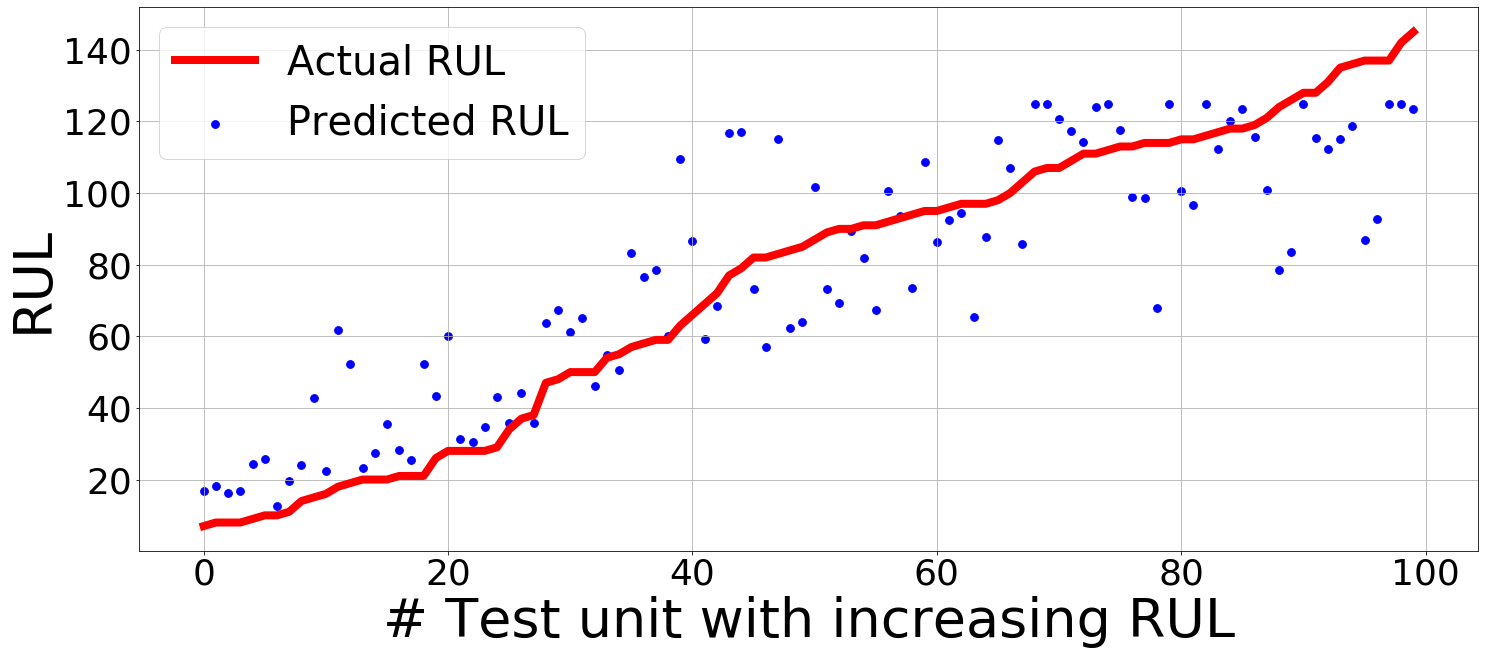

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(694.8213383791173, 18.554990606845493, 20.987260882469876)

In [349]:
# FD001
sequence_length = 90 
lambda_ = 0.8

filename = 'FD001'
train_df, test_df, truth_df = read_data(filename)
train_df, test_df = data_handle(train_df, test_df, truth_df)
sequence_cols = ['s' + str(i) for i in set(range(1, 22))] + ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols = [x for x in sequence_cols if x not in ['s1','s5','s10','s16','s18','s19','setting3']]

model1 = load_model_from_disk_opt('BEST-FD001')
evaluate(test_df, model1, upper=125, title='FD001')

Score:  1814.553630727499
RMSE:  19.519902204922023
MSE:  381.0265820897196
Penalized RMSE:  21.401491818957915


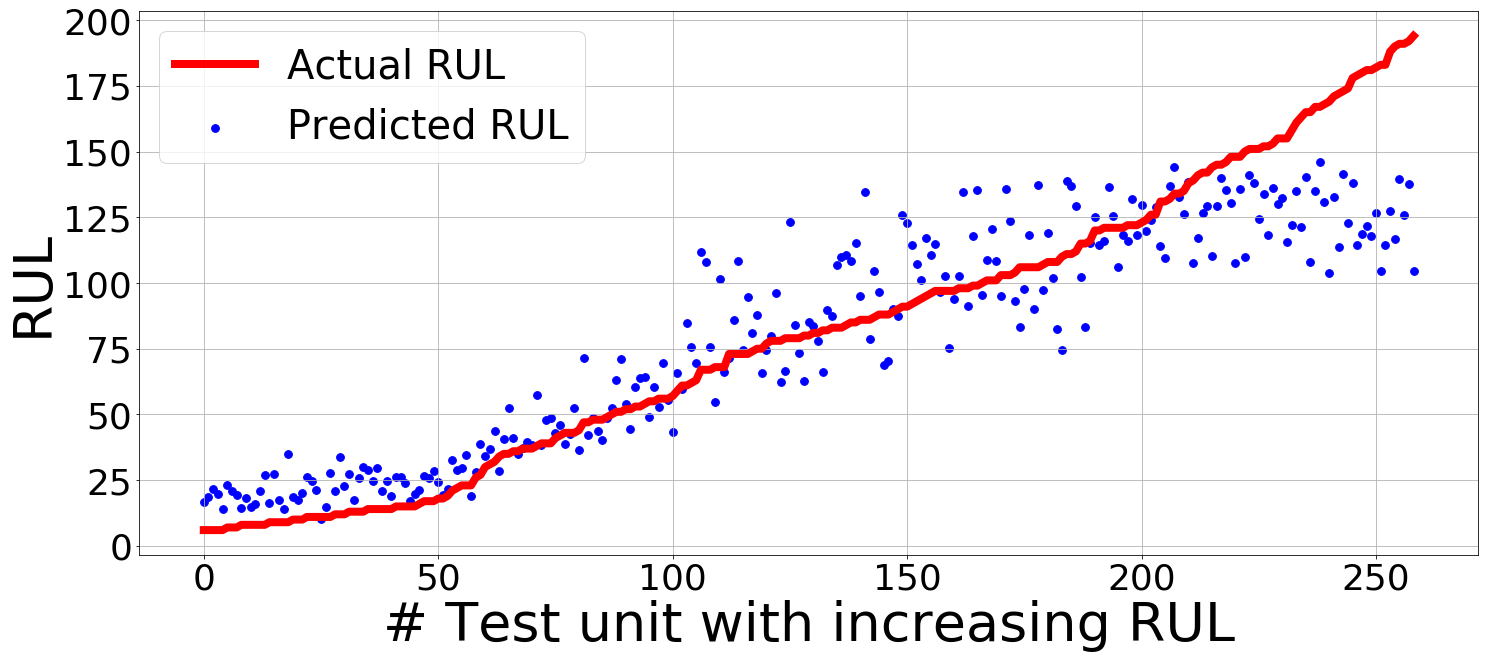

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(1814.553630727499, 19.519902204922023, 21.401491818957915)

In [226]:
# FD002
sequence_length = 90 
lambda_ = 0.8

filename = 'FD002'
train_df, test_df, truth_df = read_data(filename)
train_df, test_df = data_handle(train_df, test_df, truth_df)
sequence_cols = ['s' + str(i) for i in set(range(1, 22))] + ['setting1', 'setting2', 'setting3', 'cycle_norm']

model2 = load_model_from_disk_opt('BEST-FD002')
evaluate(test_df, model2, upper=160, title='FD002')

Score:  459.41961148963566
RMSE:  13.496852586200944
MSE:  182.16502973363913
Penalized RMSE:  15.692520614920113


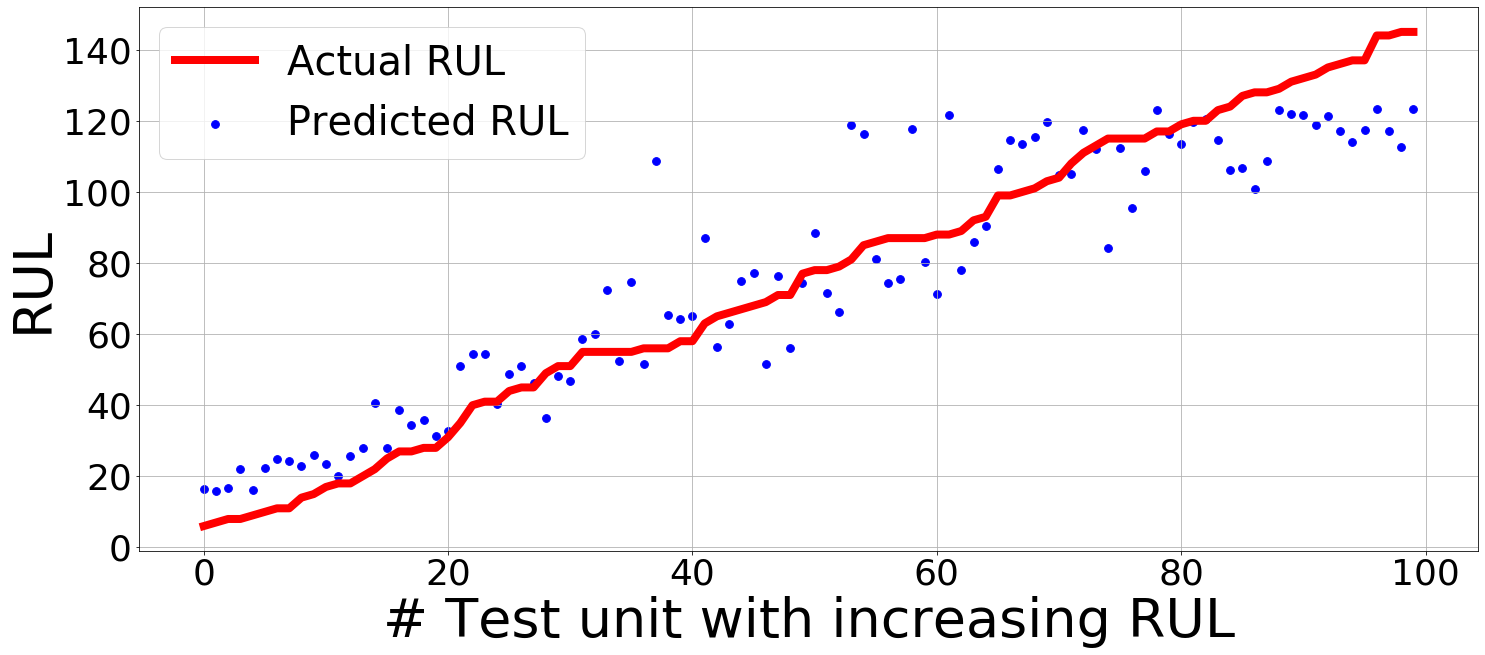

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(459.41961148963566, 13.496852586200944, 15.692520614920113)

In [350]:
# FD003
sequence_length = 90 
lambda_ = 0.8

filename = 'FD003'
train_df, test_df, truth_df = read_data(filename)
train_df, test_df = data_handle(train_df, test_df, truth_df)
sequence_cols = ['s' + str(i) for i in set(range(1, 22))] + ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols = [x for x in sequence_cols if x not in ['s1','s5','s16','s18','s19', 'setting3']]

model3 = load_model_from_disk_opt('BEST-FD003')
evaluate(test_df, model3, upper=125, title='FD003')

Score:  2502.3574449473217
RMSE:  20.674245614825537
MSE:  427.4244317421329
Penalized RMSE:  22.83963458619024


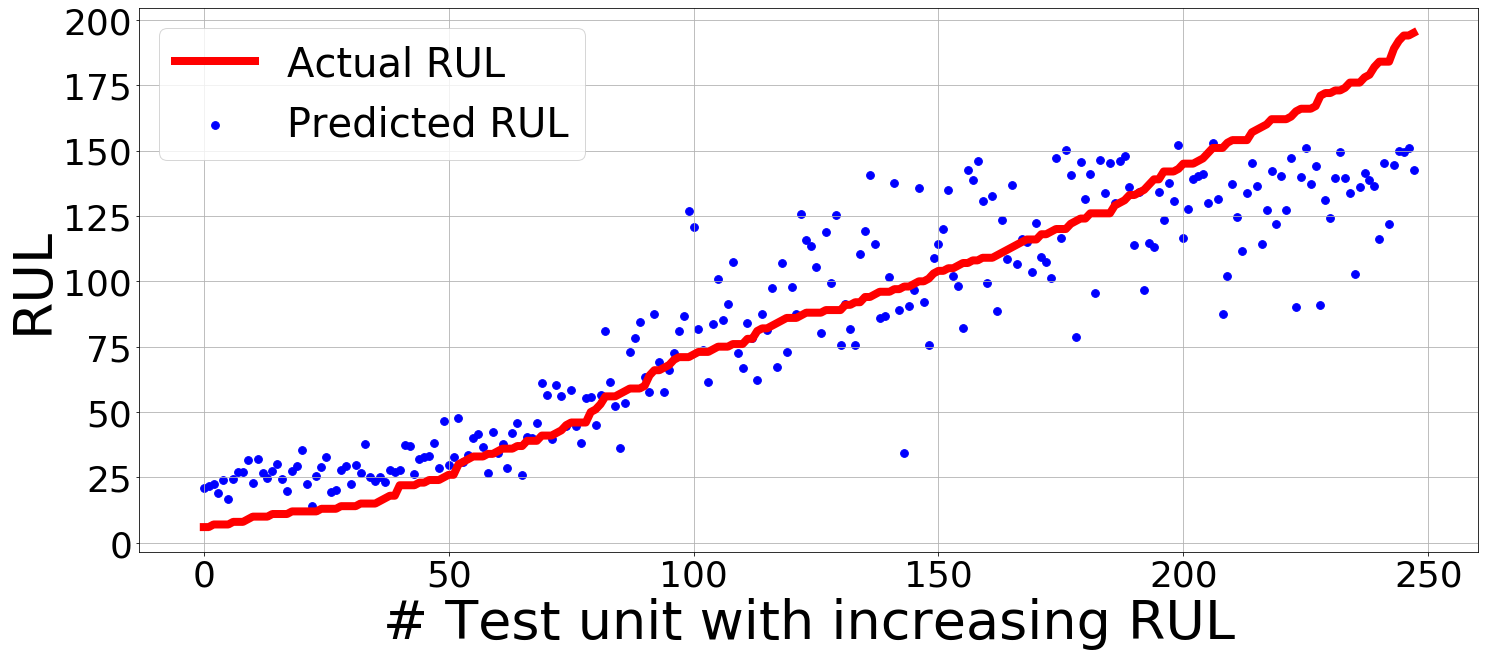

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(2502.3574449473217, 20.674245614825537, 22.83963458619024)

In [244]:
# FD004
sequence_length = 90 
lambda_ = 0.8

filename = 'FD004'
train_df, test_df, truth_df = read_data(filename)
train_df, test_df = data_handle(train_df, test_df, truth_df)
sequence_cols = ['s' + str(i) for i in set(range(1, 22))] + ['setting1', 'setting2', 'setting3', 'cycle_norm']

model4 = load_model_from_disk_opt('BEST-FD004')
evaluate(test_df, model4, upper=160, title='FD004')

## 比较三个Loss Function

In [172]:
def compute_score(y_true, y_pred):
    d = y_pred - y_true
    return np.sum(np.exp(d[d >= 0] / 10) - 1) + np.sum(np.exp(-1 * d[d < 0] / 13) - 1)

def compute_rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true))) 

def compute_penalized_rmse(y_true, y_pred):
    diff = y_pred - y_true
    positive = np.maximum(diff, 0) # loss is bigger
    negative = np.minimum(diff, 0) # loss is less
    return np.sqrt(np.mean(np.square(positive) * (0.5 + 1) + np.square(negative)))
    

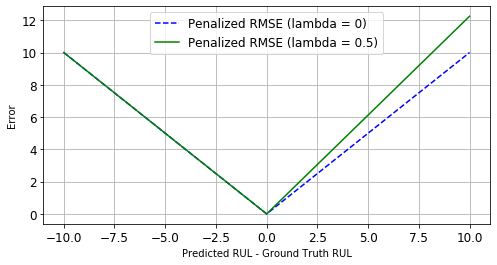

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [175]:
predict_ = list(range(90, 111))
real_ = 100

# 计算三个Loss的具体数值
score_value = []
rmse_value = []
custom_rmse_value = []
for i in range(len(predict_)):
    score_value.append(compute_score(np.array(real_), np.array(predict_[i])))
    rmse_value.append(compute_rmse(real_, predict_[i]))
    custom_rmse_value.append(compute_penalized_rmse(real_, predict_[i]))
    
# 画图
fig = plt.figure(figsize = (8, 4))
plt.grid(True)


plt.plot(list(range(-10, 11)), rmse_value, 'b--') 
plt.plot(list(range(-10, 11)), custom_rmse_value, 'green')


plt.xlabel('Predicted RUL - Ground Truth RUL')
plt.xticks(fontsize=12)
plt.ylabel('Error')
plt.yticks(fontsize=12)
plt.legend(['Penalized RMSE (lambda = 0)', 'Penalized RMSE (lambda = 0.5)'],  loc='best', fontsize=12)
plt.show()

# 保存
fig.savefig('./plot/loss-comparison.eps', dpi=600, format='eps')

## 查看 lambda 参数对结果的影响

In [ ]:
file_list = ['FD004']
sequence_length = 100
lambda_set = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
result = []
for lambda_ in lambda_set:
    def score(y_true, y_pred):
        diff = y_pred - y_true
        positive = K.maximum(diff, 0)
        negative = K.minimum(diff, 0)
        return K.sqrt(K.mean(K.square(positive) * (1 + lambda_) + K.square(negative)))
    
    def compute_penalized_rmse(y_true, y_pred):
        diff = y_pred - y_true
        positive = np.maximum(diff, 0)
        negative = np.minimum(diff, 0)
        return np.sqrt(np.mean(np.square(positive) * (1 + lambda_) + np.square(negative)))
    
    for index, file in enumerate(file_list):
        sequence_cols = ['s' + str(i) for i in set(range(1, 22))] + ['setting1', 'setting2', 'setting3', 'cycle_norm']
        upper = 160
        
        train_df, test_df, truth_df = read_data(file)
        train_df, test_df = data_handle(train_df, test_df, truth_df)
        seq_array, label_array = split(train_df, sequence_length, sequence_cols, upper)

        model = build_model(seq_array.shape[2], sequence_length)
        history = model.fit(
            x=seq_array, 
            y={'output': label_array, 'reconstruction': seq_array},
            epochs=200, 
            batch_size=128 * 8,
            verbose=0, 
            validation_split=0.2,
            callbacks = [
                keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='min'),
                keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-8),
            ])
        
        print(lambda_, file)
        a, b, c = evaluate(test_df, model, upper=upper, plot_=False)
        result.append(str(lambda_) + ', ' + str(file) + ': ' + str(a) + ',' + str(b) + ',' + str(c) + ',' + str(np.sqrt(a) + b) +'\n')
    print('---------------')

np.save('./ckpt_opt/effect_on_lambda', np.array(result))

 ## 查看 Sequence Length 参数对结果的影响

In [ ]:
file_list = ['FD004']
seq_set = [60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110]
result = []
lambda_ = 0.5
for sequence_length in seq_set:
    for index, file in enumerate(file_list):
        sequence_cols = ['s' + str(i) for i in set(range(1, 22))] + ['setting1', 'setting2', 'setting3', 'cycle_norm']
        upper = 160
        
        train_df, test_df, truth_df = read_data(file)
        train_df, test_df = data_handle(train_df, test_df, truth_df)
        seq_array, label_array = split(train_df, sequence_length, sequence_cols, upper)

        model = build_model(seq_array.shape[2], sequence_length)
        
        history = model.fit(
            x=seq_array,
            y={'output': label_array, 'reconstruction': seq_array},
            epochs=200,
            batch_size=128 * 8,
            verbose=0,
            validation_split=0.2,
            callbacks=[
                keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='min'),
                keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-8),
            ])
        print(sequence_length, file)
        a, b, c = evaluate(test_df, model,  upper=upper, plot_=False)
        
        result.append(str(sequence_length) + ', ' + str(file) + ': ' + str(a) + ',' + str(b) + ',' + str(c) + ',' + str(np.sqrt(a) + b) + '\n')
    print('---------------')

np.save('./ckpt_opt/effect_on_sequence', np.array(result))


## 2个影响因素都查看

In [6]:
file_list = ['FD004']
seq_set = [70, 80, 90, 100, 110, 120, 130]
lambda_set = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4]
result = []
for lambda_ in lambda_set:
    def score(y_true, y_pred):
            diff = y_pred - y_true
            positive = K.maximum(diff, 0)
            negative = K.minimum(diff, 0)
            return K.sqrt(K.mean(K.square(positive) * (1 + lambda_) + K.square(negative)))

    def compute_penalized_rmse(y_true, y_pred):
        diff = y_pred - y_true
        positive = np.maximum(diff, 0)
        negative = np.minimum(diff, 0)
        return np.sqrt(np.mean(np.square(positive) * (1 + lambda_) + np.square(negative)))

    for sequence_length in seq_set:
        for index, file in enumerate(file_list):
            sequence_cols = ['s' + str(i) for i in set(range(1, 22))] + ['setting1', 'setting2', 'setting3', 'cycle_norm']
            upper = 160

            train_df, test_df, truth_df = read_data(file)
            train_df, test_df = data_handle(train_df, test_df, truth_df)
            seq_array, label_array = split(train_df, sequence_length, sequence_cols, upper)

            model = build_model(seq_array.shape[2], sequence_length)
            history = model.fit(
                x=seq_array, 
                y={'output': label_array, 'reconstruction': seq_array},
                epochs=200, 
                batch_size=128 * 8,
                verbose=0, 
                validation_split=0.2,
                callbacks = [
                    keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='min'),
                    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-8),
                    keras.callbacks.ModelCheckpoint(filepath='./ckpt_opt/' + str(lambda_) + ' ' + str(sequence_length) + '.h5', monitor='val_loss', save_best_only=True, verbose=1)
                ])
        
            print(lambda_, sequence_length, file)
            a, b, c = evaluate(test_df, model, upper=upper, plot_=False)
            
            result.append('{},{},{},{},{},{},{} \n'.format(
                str(lambda_),
                str(sequence_length),
                str(file),
                str(a),
                str(b),
                str(c),
                str(np.sqrt(a) + b)
            ))
        print('---------------')

np.save('./ckpt_opt/effect_on_all', np.array(result))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Epoch 00001: val_loss improved from inf to 94.83389, saving model to ./ckpt_opt/0 70.h5

Epoch 00002: val_loss did not improve from 94.83389

Epoch 00003: val_loss did not improve from 94.83389

Epoch 00004: val_loss improved from 94.83389 to 94.21875, saving model to ./ckpt_opt/0 70.h5

Epoch 00005: val_loss improved from 94.21875 to 92.20425, saving model to ./ckpt_opt/0 70.h5

Epoch 00006: val_loss did not improve from 92.20425

Epoch 00007: val_loss did not improve from 92.20425

Epoch 00008: val_loss improved from 92.20425 to 90.40760, saving model to ./ckpt_opt/0 70.h5

Epoch 00009: val_loss improved from 90.40760 to 84.70968, saving model to ./ckpt_opt/0 70.h5

Epoch 000

In [7]:
result

['0,70,FD004,4893.575301817399,24.220345346451616,24.220345346451616,94.17443959273143 \n',
 '0,80,FD004,9563.09340836566,26.601231566172746,26.601231566172746,124.39230175341254 \n',
 '0,90,FD004,5099.826330692138,25.586444883044635,25.586444883044635,96.99951322975649 \n',
 '0,100,FD004,3638.3206083619048,22.57275625885059,22.57275625885059,82.89124934647592 \n',
 '0,110,FD004,3815.9335531830525,22.45795794981618,22.45795794981618,84.23120096961442 \n',
 '0,120,FD004,4747.827078910243,24.71377367727564,24.71377367727564,93.6182516080331 \n',
 '0,130,FD004,8321.657999621886,26.005529493276228,26.005529493276228,117.22865156011784 \n',
 '0.1,70,FD004,8022.641847200835,25.626640145733322,26.456053019895506,115.19584158909127 \n',
 '0.1,80,FD004,7406.941167296629,25.342659288906514,26.397364897707938,111.40624721839403 \n',
 '0.1,90,FD004,3525.10505311057,22.94364180766466,23.811462531998036,82.31623694305158 \n',
 '0.1,100,FD004,3127.241744644385,22.06898927841287,22.872212304798147,77.

## 噪音Simga对结果的影响

In [18]:
filename = 'FD004'
lambda_ = 0.8
sequence_length = 90
train_df, test_df, truth_df = read_data(filename)
train_df, test_df = data_handle(train_df, test_df, truth_df)
sequence_cols = ['s' + str(i) for i in set(range(1, 22))] + ['setting1', 'setting2', 'setting3', 'cycle_norm']

model4 = load_model_from_disk_opt("0.8 90")

all_rmse_mean = []
all_score_mean = []

all_rmse_std = []
all_score_std = []

for i in range(20):
    loss_list = []
    score_list = []
    for sigma in [0.0, 0.01, 0.04, 0.09]:
        score_, rmse_, _ =  evaluate(test_df, model4, upper=160, plot_=False, noise=True, sigma=sigma, debug=False)
        loss_list.append(rmse_)
        score_list.append(score_)

        print("{}, \t {}, {}".format(round(sigma, 2), round(score_, 2), round(rmse_, 2)))
        
    print('===============')
    all_rmse_mean.append(np.mean(loss_list))
    all_score_mean.append(np.mean(score_list))
    
    all_rmse_std.append(np.std(loss_list))
    all_score_std.append(np.std(score_list))

0.0, 	 2027.12, 20.88
0.01, 	 2941.83, 21.93
0.04, 	 2200.27, 21.36
0.09, 	 5165.33, 23.88
0.0, 	 2027.12, 20.88
0.01, 	 1844.83, 20.93
0.04, 	 2430.52, 21.75
0.09, 	 5394.32, 23.82
0.0, 	 2027.12, 20.88
0.01, 	 2580.55, 22.06
0.04, 	 2686.95, 21.45
0.09, 	 2493.33, 22.01
0.0, 	 2027.12, 20.88
0.01, 	 2171.59, 21.61
0.04, 	 2451.25, 22.1
0.09, 	 4074.32, 23.15
0.0, 	 2027.12, 20.88
0.01, 	 2243.59, 21.58
0.04, 	 2121.03, 21.42
0.09, 	 9603.54, 22.79
0.0, 	 2027.12, 20.88
0.01, 	 3880.68, 22.05
0.04, 	 3157.11, 22.62
0.09, 	 4557.47, 24.12
0.0, 	 2027.12, 20.88
0.01, 	 2755.6, 21.9
0.04, 	 2911.19, 22.39
0.09, 	 3714.96, 21.68
0.0, 	 2027.12, 20.88
0.01, 	 2680.35, 22.11
0.04, 	 2221.59, 21.14
0.09, 	 6289.59, 23.26
0.0, 	 2027.12, 20.88
0.01, 	 2771.8, 22.39
0.04, 	 3000.67, 22.06
0.09, 	 4963.93, 23.11
0.0, 	 2027.12, 20.88
0.01, 	 2482.63, 21.83
0.04, 	 2969.08, 22.25
0.09, 	 2502.86, 22.35
0.0, 	 2027.12, 20.88
0.01, 	 2499.47, 22.14
0.04, 	 2253.22, 21.82
0.09, 	 2789.57, 22.67
0.0

In [22]:
filename = 'FD004'
lambda_ = 0.8
sequence_length = 90
train_df, test_df, truth_df = read_data(filename)
train_df, test_df = data_handle(train_df, test_df, truth_df)
sequence_cols = ['s' + str(i) for i in set(range(1, 22))] + ['setting1', 'setting2', 'setting3', 'cycle_norm']

model4 = load_model_from_disk_opt("0.8 90")

all_rmse_mean = []
all_score_mean = []

all_rmse_std = []
all_score_std = []

for i in range(20):
    loss_list = []
    score_list = []
    for sigma in [0.01, 0.04, 0.09, 0.16]:
        score_, rmse_, _ =  evaluate(test_df, model4, upper=160, plot_=False, noise=True, sigma=sigma, debug=False)
        loss_list.append(rmse_)
        score_list.append(score_)

        print("{}, \t {}, {}, {}".format(round(sigma, 2), round(score_, 2), round(rmse_, 2), round(np.sqrt(score_) + rmse_), 2))
        
    print('===============')
    all_rmse_mean.append(np.mean(loss_list))
    all_score_mean.append(np.mean(score_list))
    
    all_rmse_std.append(np.std(loss_list))
    all_score_std.append(np.std(score_list))

0.01, 	 2436.68, 21.74, 71.0
0.04, 	 2401.12, 21.47, 70.0
0.09, 	 3527.87, 23.16, 83.0
0.16, 	 20763.55, 28.63, 173.0
0.01, 	 2895.93, 21.62, 75.0
0.04, 	 1939.27, 21.06, 65.0
0.09, 	 4094.18, 23.11, 87.0
0.16, 	 17925.94, 26.53, 160.0
0.01, 	 2373.78, 21.67, 70.0
0.04, 	 2407.98, 22.14, 71.0
0.09, 	 3332.6, 22.47, 80.0
0.16, 	 62751.99, 27.3, 278.0
0.01, 	 2298.64, 21.04, 69.0
0.04, 	 2762.36, 22.17, 75.0
0.09, 	 2639.53, 22.2, 74.0
0.16, 	 14037.25, 26.75, 145.0
0.01, 	 2855.07, 21.53, 75.0
0.04, 	 2407.57, 21.87, 71.0
0.09, 	 5615.9, 23.32, 98.0
0.16, 	 6794.52, 25.0, 107.0
0.01, 	 2690.13, 21.43, 73.0
0.04, 	 3272.65, 22.33, 80.0
0.09, 	 6062.56, 23.73, 102.0
0.16, 	 9719.09, 25.88, 124.0
0.01, 	 2637.26, 21.77, 73.0
0.04, 	 7021.37, 22.95, 107.0
0.09, 	 11260.21, 24.82, 131.0
0.16, 	 6296.85, 24.7, 104.0
0.01, 	 2142.43, 21.6, 68.0
0.04, 	 3214.22, 22.42, 79.0
0.09, 	 3368.39, 23.04, 81.0
0.16, 	 11769.25, 25.55, 134.0
0.01, 	 2351.05, 21.55, 70.0
0.04, 	 2218.3, 21.36, 68.0
0.09,

## Point-wise Linear Degradation Model

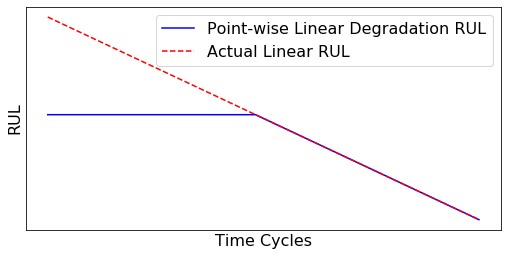

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [269]:
max_degradation = 130
actual_rul = list(range(250, 0, -1))
degradation_rul = list(range(250, 0, -1))
degradation_rul[:(250 - max_degradation)] = [max_degradation] * (250 - max_degradation)

# 画图
fig = plt.figure(figsize = (8.5, 4.1))
plt.grid(True)
plt.plot(list(range(0, 250)), degradation_rul, 'b-')
plt.plot(list(range(0, 250)), actual_rul, 'red', linestyle='--')
plt.xlabel('Time Cycles', fontsize=16)
# plt.xticks(fontsize=12)
plt.xticks([])
plt.ylabel('RUL' , fontsize=16)
# plt.yticks(fontsize=12)
plt.yticks([])
plt.legend(['Point-wise Linear Degradation RUL', 'Actual Linear RUL', ],loc='best', fontsize=16)
plt.show()

# 保存
fig.savefig('./plot/point-wise-linear-degradation.eps', dpi=600, format='eps')